In [3]:
# Evaluation mean f1-score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

X = np.load('data/train_data.npy')
# classes 0 - 3
y = np.genfromtxt('data/train_labels.csv', delimiter=' ', dtype=np.float32)

unique, counts = np.unique(y, return_counts=True)
print(counts) # features: 18286

[4040 1965  227  590]


[3000 1500  180  450]


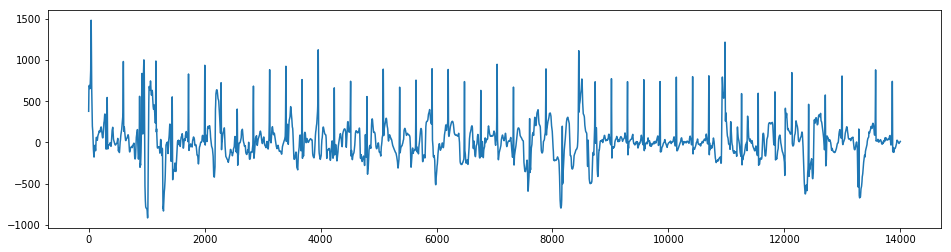

0.0
0.07417179712694225


In [4]:
from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state=384, n_jobs=-1)

ind_train = np.concatenate((np.where(y == 0)[0][0:3000], np.where(y == 1)[0][:1500], np.where(y == 2)[0][:180], np.where(y == 3)[0][:450]))
ind_test = list(set(range(0, len(X))) - set(ind_train))

X_train = np.take(X, ind_train, axis=0)
y_train = np.take(y, ind_train, axis=0)
X_test = np.take(X, ind_test, axis=0)
y_test = np.take(y, ind_test, axis=0)

unique, counts = np.unique(y_train, return_counts=True)
print(counts) # features: 18286

i = 9
plt.figure(figsize=(16,4))
plt.plot(range(len(X[i][:14000])), X[i][:14000])
plt.show()
print(y[i])



c = 0
for i, x in enumerate(X):
    if np.sum(x[17000:])>0: 
        #print(y[i])
        c += 1
print(c / len(X))

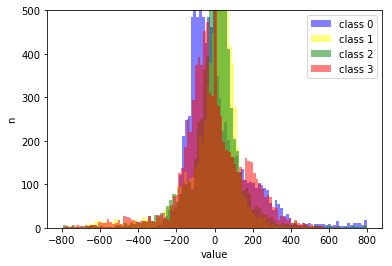

In [28]:
min_v = -800; max_v = 800;
plt.hist(X[0][(X[0] > min_v) & (X[0] < max_v) ], 100, facecolor='blue', alpha=0.5, label='class 0')
plt.hist(X[3][(X[3] > min_v) & (X[3] < max_v) ], 100, facecolor='yellow', alpha=0.5, label='class 1')
plt.hist(X[45][(X[45] > min_v) & (X[45] < max_v) ], 100, facecolor='green', alpha=0.5, label='class 2')
plt.hist(X[500][(X[500] > min_v) & (X[500] < max_v) ], 100, facecolor='red', alpha=0.5, label='class 3')
plt.ylim([0, 500])
plt.xlabel('value'); plt.ylabel('n'); plt.legend(); plt.show()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from biosppy.signals import ecg
import random
random.seed(99)

class RandomBinsExtraction(BaseEstimator, TransformerMixin):
    """Build n bins with mean from values"""
    def __init__(self, splits=100, hist_bins=None):
        self.splits = splits
        self.hist_bins = hist_bins
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_new = []
        if self.hist_bins is None:
            self.hist_bins = [np.array([-1120.92739703,  -410.10302004,  -381.9367802 ,  -378.56527536,
        -174.60213944,   -44.34063315,   156.85575077,   267.69506558,
         339.42342893,   813.9679836 ,   973.56013152]), np.array([-1073.60184133,  -455.90183329,  -444.16046402,  -266.4309005 ,
        -136.41610024,    40.3241323 ,    82.42961269,   207.59071535,
         357.33894262,   797.85851412,  1104.19371508]), np.array([-1128.03563039,  -481.61721441,  -391.8380545 ,  -325.81087844,
        -100.55385922,    48.40905487,   145.29084922,   226.92310913,
         317.45573457,   679.60216005,  1042.88557759]), np.array([-975.7356248 , -552.58462036, -424.33531124, -244.59278393,
       -135.65844452,  -25.19848856,   65.99641195,  155.68679013,
        304.85466499,  524.97382413,  831.98856301]), np.array([ -964.60670382,  -477.64948448,  -385.7512008 ,  -315.21349457,
        -152.84926029,   -85.25289273,   156.42983286,   171.08830827,
         344.61128683,   632.58777948,  1012.74471941]), np.array([-1134.21396667,  -538.43695698,  -383.55196108,  -351.25518606,
        -234.1447024 ,   -76.85460874,    45.68341725,   179.81290443,
         283.45827579,   801.8892079 ,  1042.60967834]), np.array([ -992.1077973 ,  -543.54694461,  -375.95005102,  -303.90048148,
        -143.67198451,    56.16762597,    66.44392725,   207.85237126,
         380.28994569,   710.663395  ,  1041.77862555]), np.array([ -1.17059017e+03,  -4.53066930e+02,  -2.50693013e+02,
        -2.16122392e+02,  -1.31726746e+02,   1.13214948e+00,
         1.68241723e+02,   2.78649977e+02,   2.80757863e+02,
         7.83644496e+02,   9.68362007e+02]), np.array([-1087.66293359,  -549.50278667,  -408.46803696,  -277.20450193,
        -166.07720166,  -120.21777927,   127.31179008,   148.01407036,
         305.00966007,   518.83427404,   899.85406707]), np.array([-986.95299053, -503.2626519 , -433.34977809, -336.10288443,
       -183.63535388, -119.99037903,   96.05301919,  163.90039389,
        330.43404621,  765.67693595,  976.66567793]), np.array([-1099.08114631,  -528.03389226,  -335.17289441,  -212.82031621,
        -135.27839074,  -103.23247183,    58.56529893,   250.12959902,
         302.70520695,   752.02364255,  1007.3171732 ]), np.array([-1001.27139698,  -579.35034134,  -428.72446755,  -235.21167415,
        -126.52974159,  -118.11977088,    39.87136329,    74.37218865,
         244.81062741,   582.77849189,   872.47943575]), np.array([-1074.94606534,  -597.91369575,  -504.88658494,  -393.98020568,
        -130.40952056,   -74.93929184,    77.38499856,   255.65596205,
         288.87841233,   715.22901152,   975.36521957])]
        
        k=0
        for row in X:
            splits = np.array_split(row, int(self.splits))
                
            features = []
            for j, split in enumerate(splits):
                i = int(j / len(splits) * len(self.hist_bins))
                features.append(np.histogram(split, bins=self.hist_bins[i])[0])
                #features.append(np.histogram(split, bins=self.hist_bins)[0])

            try:
                e = ecg.ecg(row, show=False)
            except:
                e = {
                    "rpeaks": [], "heart_rate": [], 
                    "templates_ts": [], "templates": []
                }
            rr = np.zeros(30)
            rr[:len(e['heart_rate'])] = e['heart_rate'][:30]
            features.append(rr)
            rr = np.zeros(50)
            rr[:len(e['templates_ts'])] = e['templates_ts'][:50]
            features.append(rr)

            features.append([len(e['rpeaks']), len(e['heart_rate']), len(e['templates'])])
            
            X_new.append(np.hstack(features))#.flatten())
            k+=1
            if k%1000 == 0:
                print("{} done".format(k))

        #print("features: "+str(len(X_new[0])))
        print(np.array(X_new).shape)
        return X_new
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler #, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.svm import LinearSVC
#from sklearn.neural_network import MLPClassifier

pipe = Pipeline([
    ('BinsExtraction', RandomBinsExtraction(splits=80)),
    ('scaler', StandardScaler()),
    ('gbc', GradientBoostingClassifier(n_estimators=50, random_state=3))#, subsample=0.7, random_state=3))
    #('cnn', MLPClassifier(solver='sgd', learning_rate='adaptive', alpha=1e-5,
     #                hidden_layer_sizes=(100,50), random_state=1))
#      ('linearSVC', LinearSVC(C=1.0, max_iter=1000))
])

In [ ]:
from sklearn.metrics import f1_score

pipe.fit(X_train, y_train) #; print('fitted')
y_pred = pipe.predict(X_test);
print("f1 score: {}".format(f1_score(y_test, y_pred, average='micro') ))

unique, counts = np.unique(y_pred, return_counts=True)
print(counts); #print(len(y_test[y_test==0]) / len(y_test))

# Pass score: 0.62837
# Splits 80: 0.5739644970414202 (first class 2000 rows)
# GradientBoostingClassifier, 100, 0.6505588428665352
# 30, 0.6794871794871795 / 0.7176820208023774 [2200  463   26    3]
# Smote 4x2000: 0.5197409006785935
# 45: 0.6524
# 50: 0.6542, 0.676 (ecg)
# 60: 0.6501
# 100: 0.644, subsample = 0.7

In [74]:
import random
from sklearn.metrics import f1_score
def run(a):
    pipe = Pipeline([
        ('BinsExtraction', RandomBinsExtraction(splits=80, hist_bins=a)),
        ('scaler', StandardScaler()),
 #       ('logreg', LogisticRegression(C=1.0, solver='liblinear', n_jobs=2))
        ('logreg', GradientBoostingClassifier(n_estimators=50))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test);

    score = f1_score(y_test, y_pred, average='micro')
    print("\x1b[1;31m%s\x1b[0m \t%s" % (score, a))
    
#for i in [0.01, 0.1, 1, 10]:
#    run(i)
hist_bins = [np.array([-1120.92739703,  -410.10302004,  -381.9367802 ,  -378.56527536,
        -174.60213944,   -44.34063315,   156.85575077,   267.69506558,
         339.42342893,   813.9679836 ,   973.56013152]), np.array([-1073.60184133,  -455.90183329,  -444.16046402,  -266.4309005 ,
        -136.41610024,    40.3241323 ,    82.42961269,   207.59071535,
         357.33894262,   797.85851412,  1104.19371508]), np.array([-1128.03563039,  -481.61721441,  -391.8380545 ,  -325.81087844,
        -100.55385922,    48.40905487,   145.29084922,   226.92310913,
         317.45573457,   679.60216005,  1042.88557759]), np.array([-975.7356248 , -552.58462036, -424.33531124, -244.59278393,
       -135.65844452,  -25.19848856,   65.99641195,  155.68679013,
        304.85466499,  524.97382413,  831.98856301]), np.array([ -964.60670382,  -477.64948448,  -385.7512008 ,  -315.21349457,
        -152.84926029,   -85.25289273,   156.42983286,   171.08830827,
         344.61128683,   632.58777948,  1012.74471941]), np.array([-1134.21396667,  -538.43695698,  -383.55196108,  -351.25518606,
        -234.1447024 ,   -76.85460874,    45.68341725,   179.81290443,
         283.45827579,   801.8892079 ,  1042.60967834]), np.array([ -992.1077973 ,  -543.54694461,  -375.95005102,  -303.90048148,
        -143.67198451,    56.16762597,    66.44392725,   207.85237126,
         380.28994569,   710.663395  ,  1041.77862555]), np.array([ -1.17059017e+03,  -4.53066930e+02,  -2.50693013e+02,
        -2.16122392e+02,  -1.31726746e+02,   1.13214948e+00,
         1.68241723e+02,   2.78649977e+02,   2.80757863e+02,
         7.83644496e+02,   9.68362007e+02]), np.array([-1087.66293359,  -549.50278667,  -408.46803696,  -277.20450193,
        -166.07720166,  -120.21777927,   127.31179008,   148.01407036,
         305.00966007,   518.83427404,   899.85406707]), np.array([-986.95299053, -503.2626519 , -433.34977809,# -336.10288443,
       -183.63535388, -119.99037903,   96.05301919,  163.90039389,
        330.43404621,  765.67693595,  976.66567793]), np.array([-1099.08114631,  -528.03389226,  -335.17289441, # -212.82031621,
        -135.27839074,  -103.23247183,    58.56529893,   250.12959902,
         302.70520695,   752.02364255,  1007.3171732 ]), np.array([-1001.27139698,  -579.35034134,  -428.72446755,  #-235.21167415,
        -126.52974159,  -118.11977088,    39.87136329,    74.37218865,
         244.81062741,   582.77849189,   872.47943575]), np.array([-1074.94606534,  -597.91369575,  -504.88658494,  #-393.98020568,
        -130.40952056,   -74.93929184,    77.38499856,   255.65596205,
         288.87841233,   715.22901152,   975.36521957])]
#hist_bins = [[-1063.23640194,  -502.03339032,  -422.5276436,   -286.42136028,   -97.20735832,   -55.16501241,   123.49800188 ,  206.09874563 ,  337.38048621,   637.69219956,   939.23230402]]
for i in range(100):
    bins_new = []
    for b1 in hist_bins:
        bins_new2 = []
        for b2 in b1:
            bins_new2.append(random.uniform(b2 - 80, b2 + 80))
        bins_new.append(np.sort(bins_new2))
    run(bins_new)

0.649527186761 	[array([-1153.69979122,  -369.03687283,  -331.58618134,  -303.2454361 ,
        -190.85069249,   -96.78016392,   150.58731783,   208.25005024,
         280.32961015,   805.41574212,  1029.59571537]), array([-1041.30732311,  -468.99574641,  -371.4674228 ,  -317.81745074,
        -176.38926956,     4.09660738,    94.05579888,   269.95291263,
         338.56362398,   850.12497825,  1174.10540007]), array([-1131.36787148,  -418.74850768,  -329.59433969,  -329.55547327,
        -153.43679286,   -19.63168618,   103.62253309,   220.50264047,
         239.92181132,   652.36158068,  1041.94539547]), array([-1002.01547879,  -515.18820369,  -413.19643971,  -239.3108584 ,
        -114.29723893,   -11.92739243,    52.22663186,   102.24426681,
         318.95753154,   452.57197557,   757.77122689]), array([-989.82434599, -520.8565463 , -369.85081719, -344.86816598,
       -162.59628976,  -53.9669216 ,  143.26458927,  219.94500081,
        283.35806041,  580.08168463,  976.82326576]),

KeyboardInterrupt: 

In [67]:
# Get clusters as a start for the bins
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=9, n_jobs=-1, random_state=99)#, init="k-means++")

ind = np.concatenate((np.where(y == 0)[0][0:3], np.where(y == 1)[0][:3], np.where(y == 2)[0][:3], np.where(y == 3)[0][:3]))
samples = np.take(X, ind, axis=0)
centers = []
for i, sample in enumerate(samples):
    sample = sample[(sample > -500) & (sample < 500)]
    kmeans.fit(np.array([sample]).T)
    centers.append(np.sort(np.array(kmeans.cluster_centers_).flatten()))
    print(str(i+1) + ' / ' + str(len(samples)))

if False: # use all centers
    values = np.array(centers).flatten()
    values = np.sort(values)
else: # take means of centers
    values = np.mean(centers, axis=0)

#edges = [1] # leave out 0
for center_1, center_2 in zip(values[:-1], values[1:]):
    edges.append(.5 * (center_1 + center_2))
#edges.append(1700)
"""

"""
edges

Process ForkPoolWorker-131:
Process ForkPoolWorker-132:
Process ForkPoolWorker-130:
Process ForkPoolWorker-129:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/pyt

KeyboardInterrupt: 

In [77]:
import tensorflow as tf

# Convolutional Layer #1
conv1 = tf.layers.conv2d(
  inputs=X,
  filters=32,
  kernel_size=[5, 5],
  padding="same",
  activation=tf.nn.relu)

# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

# Convolutional Layer #2 and Pooling Layer #2
conv2 = tf.layers.conv2d(
  inputs=pool1,
  filters=64,
  kernel_size=[5, 5],
  padding="same",
  activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

# Dense Layer
pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
dropout = tf.layers.dropout(
  inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

# Logits Layer
logits = tf.layers.dense(inputs=dropout, units=10)



AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'

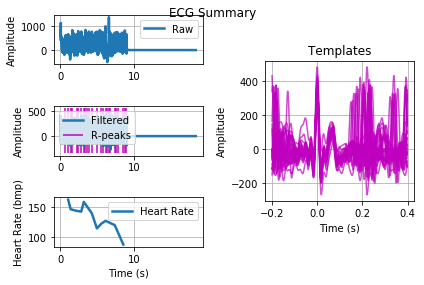

(600,)


ReturnTuple(ts=array([  0.00000000e+00,   9.99945313e-04,   1.99989063e-03, ...,
         1.82820002e+01,   1.82830001e+01,   1.82840001e+01]), filtered=array([  18.34452452,   60.20895524,  101.44318603, ...,    0.        ,
          0.        ,    0.        ]), rpeaks=array([ 649, 1041, 1374, 1600, 2168, 2397, 2811, 3151, 3382, 3625, 3855,
       4245, 4926, 5515, 5749, 6088, 6326, 6547, 6750, 7335, 7571, 7754,
       8497, 8704, 8912]), templates_ts=array([ -2.00000000e-01,  -1.99000000e-01,  -1.98000000e-01,
        -1.97000000e-01,  -1.96000000e-01,  -1.95000000e-01,
        -1.94000000e-01,  -1.93000000e-01,  -1.92000000e-01,
        -1.91000000e-01,  -1.90000000e-01,  -1.89000000e-01,
        -1.88000000e-01,  -1.87000000e-01,  -1.86000000e-01,
        -1.85000000e-01,  -1.84000000e-01,  -1.83000000e-01,
        -1.82000000e-01,  -1.81000000e-01,  -1.80000000e-01,
        -1.79000000e-01,  -1.78000000e-01,  -1.77000000e-01,
        -1.76000000e-01,  -1.75000000e-01,  -1.74000000

In [108]:
from biosppy.signals import ecg

#filtered, _, _ = biosppy.tools.filter_signal(X[0])
a = ecg.ecg(X[108])
#rpeaks = ecg.hamilton_segmenter(X[100])
#list(rpeaks)[0]
#plt.plot(range(18286), a['filtered'])
#plt.show()
print(np.array(a['templates_ts']).shape)
a